### Using  Classification Models to Detect AI generated Text
**Goal:** The goal of this project is to identify more effective ways for detecting AI generated text from student submissions and evaluating the best model for detecting AI generated text. We will be training and tuning few binary text classification models(Decision Tree,Support Vector, Naive Bayes..) to accurately classify texts as AI generated or not. Models will be able to predict, from future/unseen text, whether the text is original content of student or AI generated. We will then evaluate and compare the models' performances to identify the best one. Lastly, we will draw insights from our analyses and recommmend areas to research and courses to undertake for future work in detecting AI generated text.

**Data Problem:** The data task is to train and tune multiple binary text classification models that group texts into AI generated and non-AI generated texts

**Expected Results:** The expected results of this project is a quality model with high accuracy that can be used to predict, from future/unseen texts, whether the texts are AI generated or not


**Data**

The dataset used is from [Kaggle Competition ](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-llm-detect-ai-generate)

#### Imports
Importing required packages for the project

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import time
import warnings
import string

#Import all models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score

import nltk
nltk.download('punkt_tab')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
from nltk.stem import PorterStemmer
from nltk.corpus import words


warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


#### Setup
The data is loaded into dataframes

In [2]:
#Load essay text
essays_df=pd.read_csv("data/train_essays.csv")

In [3]:
essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
# Load prompts given for the text/essays generated
train_prompts_df=pd.read_csv("data/train_prompts.csv")

In [5]:
train_prompts_df

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [6]:
train_prompts_df['instructions']

,instructions
0,Write an explanatory essay to inform fellow ci...
1,Write a letter to your state senator in which ...


In [7]:
#create prompt column in essays_df
essays_df['prompt'] = essays_df['prompt_id'].map({
    0: 'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.',
    1: 'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'
})

### Load Data and Appky Visualizations to understand data

In [8]:
print("Prompt_id", essays_df['prompt_id'].value_counts())
    # This shows only 2 prompts

print("generated", essays_df['generated'].value_counts())
    # generated=0 Indicates that student's real work while generated=1 tells that an LLM was used to generate the essay.
    #That implies we dont have enough data to detect LLM generated text.

Prompt_id prompt_id
0    708
1    670
Name: count, dtype: int64
generated generated
0    1375
1       3
Name: count, dtype: int64


In [9]:
essays_df[essays_df['generated']==1]

,id,prompt_id,text,generated,prompt
704,82131f68,1,"This essay will analyze, discuss and prove one...",1,Write a letter to your state senator in which ...
740,86fe4f18,1,I strongly believe that the Electoral College ...,1,Write a letter to your state senator in which ...
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1,Write an explanatory essay to inform fellow ci...


In [10]:
# create source column in essays_df
essays_df['source'] = essays_df['generated'].map({
    0: 'human',
    1: 'gpt'
})

In [11]:
essays_df=essays_df[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from essays Dataset')

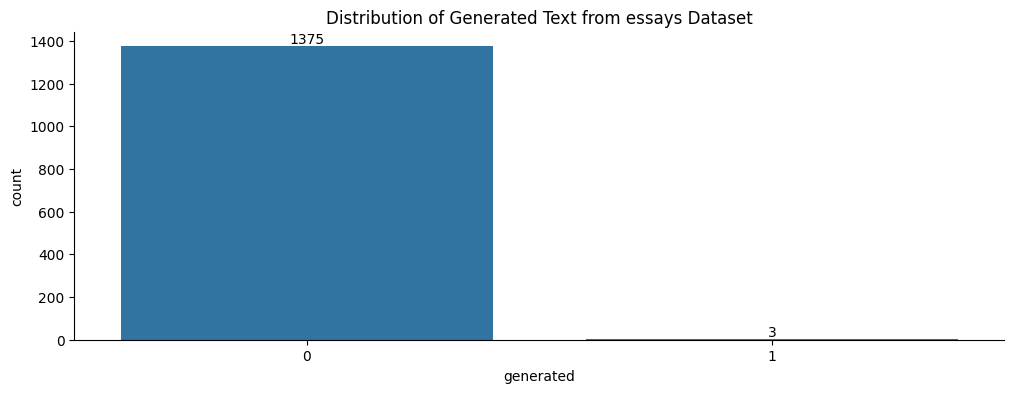

In [12]:
# Plot value counts of the texts
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=essays_df,
                   x="generated")

abs_values = essays_df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from essays Dataset")

In [13]:
#Load data from Argumentative Generative Data
gpt_df=pd.read_csv("data/argugpt.csv")

In [14]:
gpt_df.head()

,id,prompt_id,prompt,text,model,temperature,exam_type,score,score_level
0,weccl_30,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.50,weccl,19,high
1,weccl_51,WECCL-17,Some people think the university education is ...,There are a number of reasons why people might...,text-babbage-001,0.65,weccl,13,medium
2,weccl_48,WECCL-17,Some people think the university education is ...,There are many reasons why university educatio...,text-babbage-001,0.65,weccl,13,medium
3,weccl_50,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.65,weccl,12,low
4,weccl_55,WECCL-17,Some people think the university education is ...,There is a general consensus that university e...,text-babbage-001,0.80,weccl,13,medium


In [15]:

print("Prompt_id", gpt_df['prompt'].value_counts())
    # This shows only 2 prompts|




Prompt_id prompt
Most advertisements make products seem much better than they really are. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                                                        206
Successful people try new things and take risks rather than only doing what they already know how to do well. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                   205
It is better to have broad knowledge of many academic subjects than to specialize in one specific subject. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                      205
In twenty years, there will be fewer cars in use than there are today. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of rou

In [16]:
gpt_df['generated']=1
gpt_df['source']='gpt'
gpt_df=gpt_df[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from GPT')

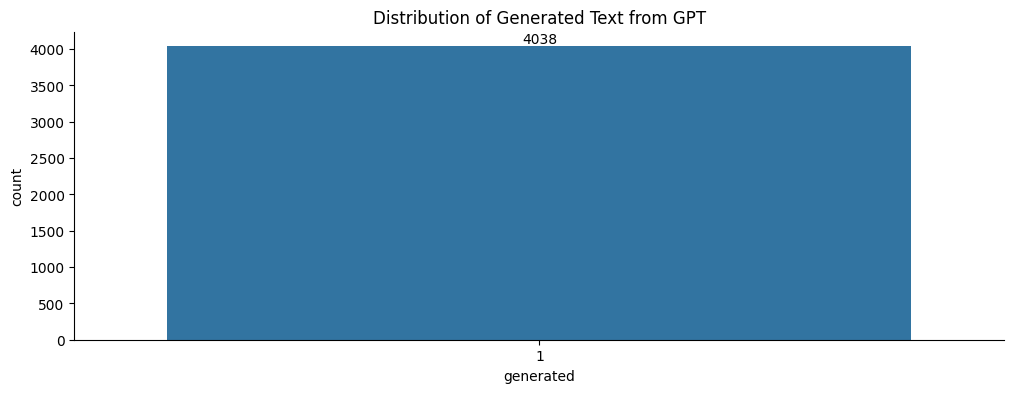

In [17]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=gpt_df,
                   x="generated")

abs_values = gpt_df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from GPT")

Add new data to the training dataset.
 We will use the dataset created by DAREK KŁECZEK

In [18]:
df_train_essays_ext = pd.read_csv('data/train_drcat_02.csv')
df_train_essays_ext.shape
df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

In [19]:
print("Prompt_id", df_train_essays_ext['generated'].value_counts())
    # This shows only 2 prompts

print("generated", df_train_essays_ext['source'].value_counts())

Prompt_id generated
0    29792
1     9993
Name: count, dtype: int64
generated source
persuade_corpus          25996
llama2_chat               2421
original_moth             2421
chat_gpt_moth             2421
llammistral7binstruct     2421
train_essays              1378
llama_70b_v1              1172
falcon_180b_v1            1055
radek_500                  500
Name: count, dtype: int64


In [20]:
df_train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E0B86027C5C5,"Okay, here is my essay:\n\nWorking or doing th...",1,llama2_chat,Task: \n\n1. Research the benefits of working ...,1
1,8B9EEF86DD66,"Dear Principal,\r\n\r\nI just want to let you ...",0,original_moth,Task: Research the effects of implementing a p...,2
2,116FB053BEC7,I believe they should change the voting to pop...,0,persuade_corpus,NaN,9
3,A72A4397F9F5,One example of an inspiring individual who has...,1,chat_gpt_moth,Task: Analyze examples of inspiring people who...,0
4,D90A159EDD27,"Dear Mr. Principal,\n\nI believe that students...",0,persuade_corpus,NaN,5


In [21]:
df_train_essays_ext=df_train_essays_ext[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from Train_Essays DataSet')

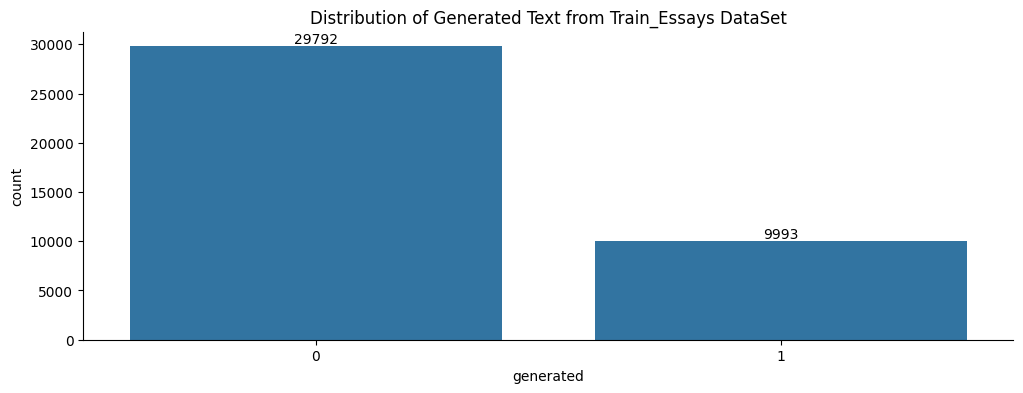

In [22]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from Train_Essays DataSet")

In [23]:
df=pd.concat([essays_df,gpt_df,df_train_essays_ext])
df_small=pd.concat([essays_df,gpt_df])

In [24]:
df.shape

(45201, 4)

In [25]:
print("Prompt_id", df_train_essays_ext['generated'].value_counts())


Prompt_id generated
0    29792
1     9993
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Generated Text From Entire DataFrame')

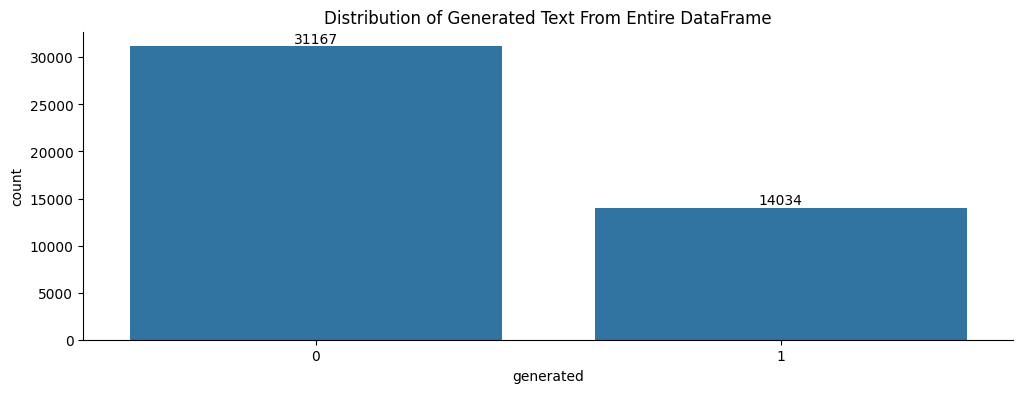

In [26]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df,
                   x="generated")

abs_values = df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text From Entire DataFrame")

In [27]:
df.describe()

,generated
count,45201.000000
mean,0.310480
std,0.462695
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [28]:
#Add column textlength to the data frame
df["text_length"] = df["text"].apply(lambda x : len(x.split()))


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45201 entries, 0 to 39784
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt       14906 non-null  object
 1   text         45201 non-null  object
 2   source       45201 non-null  object
 3   generated    45201 non-null  int64 
 4   text_length  45201 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 3000x6000 with 0 Axes>

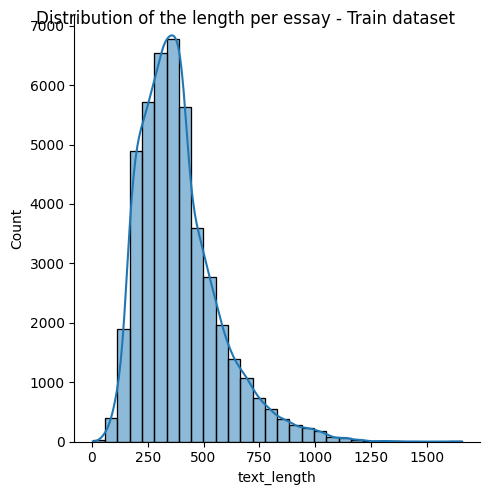

In [30]:
# Plotting the distribution of lenght per essay
fig = plt.figure(figsize=(30,60))
plot = sns.displot(data=df,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")

In [31]:
# Converting the datatypes
df['prompt'] = df['prompt'].astype(str)
df['source'] = df['source'].astype(str)
df['text'] = df['text'].astype(str)


In [32]:
# Scatter Plot
fig = px.scatter(df, x="text_length", y="generated",
                 title="Scatter Plot of Text Length vs. Generated")
fig.show()


In [33]:
# Histogram
fig = px.histogram(df, x="text_length", color="source",
                 title="Histogram of Count of Text Length by Source",
                 nbins=10,
                 labels={'text_length':'Length of Text'})
fig.show()


In [34]:
# Histogram
fig = px.histogram(df, x="source", color="generated",y="text_length",
                 title="Distribution of Sum of Text Length by Source",
                 nbins=10)
fig.show()


###Split Data

In [35]:
#Considering smaller dataset as the models take a lot of time to train
X=df_small['text']
y=df_small['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [36]:

model=DummyClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       289
           1       0.73      1.00      0.85       795

    accuracy                           0.73      1084
   macro avg       0.37      0.50      0.42      1084
weighted avg       0.54      0.73      0.62      1084

Accuracy: 0.7333948339483395


In [37]:


stemmer = PorterStemmer()
english_words = set(words.words())
def tokenizer_preprocess(text):

      tokens = nltk.word_tokenize(text)
      preprocessed_text = " ".join([stemmer.stem(token) for token in tokens if token.lower() in english_words and token not in string.punctuation])

      return preprocessed_text



In [38]:
model_results = {
    "Model": [],
    "Train Time": [],
    "Train Accuracy": [],
    "Test_accuracy": [],
    "F1Score":[],
    "Precision":[],
    "Recall":[],
}


###Feature Extraction based on CountVectorization



In [39]:
cnt_vect_pipe = Pipeline([('cvect',CountVectorizer(stop_words='english', tokenizer=tokenizer_preprocess)),('lgr',LogisticRegression())])
start_time = time.time()

X_train_cnt_vectpipe=cnt_vect_pipe.fit(X_train,y_train)
train_time = time.time() - start_time

y_pred_train = cnt_vect_pipe.predict(X_train)
cnt_vec_lr_y_pred=cnt_vect_pipe.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)

test_accuracy = accuracy_score(y_test, cnt_vec_lr_y_pred)
print("Classification Report for CountVectorizer and Logistic Regression")
print(classification_report(y_test, cnt_vec_lr_y_pred))
print("Accuracy Score",test_accuracy)
print(confusion_matrix(y_test, cnt_vec_lr_y_pred))


model_results["Model"].append("Count Vectorization+ Logistic Regression")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, cnt_vec_lr_y_pred))
model_results["Precision"].append(precision_score(y_test, cnt_vec_lr_y_pred))
model_results["Recall"].append(recall_score(y_test, cnt_vec_lr_y_pred))


Classification Report for CountVectorizer and Logistic Regression
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       289
           1       0.94      0.88      0.91       795

    accuracy                           0.87      1084
   macro avg       0.83      0.86      0.84      1084
weighted avg       0.88      0.87      0.87      1084

Accuracy Score 0.8680811808118081
[[245  44]
 [ 99 696]]


#Feature Extraction with TFIDF and applying Logistic Regression

In [53]:
#Feature Extraction with TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

In [54]:
feature_names = tfidf_vectorizer.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_vec.toarray(), columns=feature_names)
X_train_df.head()

,000,10,100,11,114,118,12,13,14,147,...,yet,york,you,young,younger,your,yourself,youth,zone,zones
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.031158,0.0,0.021307,0.0,0.0,0.028693,...,0.0,0.0,0.034056,0.0,0.0,0.01362,0.0,0.0,0.0,0.0


In [61]:
#Feature Extraction with TFIDF

tfidf_vect_pipe = Pipeline([
    ('tfidf',TfidfVectorizer(max_features=3000)),
    ('lgr',LogisticRegression())])
start_time = time.time()

tfidf_vect_pipe.fit(X_train,y_train)

train_time = time.time() - start_time

y_pred_train = tfidf_vect_pipe.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred = tfidf_vect_pipe.predict(X_test)
print("Classification Report for TFIDFVectorizer and Logistic Regression")
print(classification_report(y_test, y_pred))
test_accuracy=accuracy_score(y_test, y_pred)
print("Accuracy:",test_accuracy)
lr_pred=y_pred

model_results["Model"].append("TFIDF Vectorization+ Logistic Regression")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))



Classification Report for TFIDFVectorizer and Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       289
           1       1.00      1.00      1.00       795

    accuracy                           1.00      1084
   macro avg       1.00      0.99      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy: 0.9972324723247232


###Decision Tree and TFIDF

In [43]:
#As TFIDF Feature Extraction showed better results than CountVectorizer, lets apply different models to TFIDF feature extraction only.
tree_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier())
])
tree_params = {'tree__criterion' : ['gini', 'entropoy'],
              'tree__max_depth' : [None, 1, 2, 3, 4],
              'tree__min_samples_split' : [1, 2, 3, 4]}

start_time = time.time()
tree_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_train = tree_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred = tree_pipeline.predict(X_test)
tree_pred=y_pred
print("Classification Report for TFIDFVectorizer and Decision Tree")

print(classification_report(y_test, y_pred))
print("Accuracy Score",accuracy_score(y_test, y_pred))


model_results["Model"].append("TFIDF Vectorization+ Decision Tree")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))



Classification Report for TFIDFVectorizer and Decision Tree
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       289
           1       0.98      0.98      0.98       795

    accuracy                           0.97      1084
   macro avg       0.97      0.96      0.96      1084
weighted avg       0.97      0.97      0.97      1084

Accuracy Score 0.9704797047970479


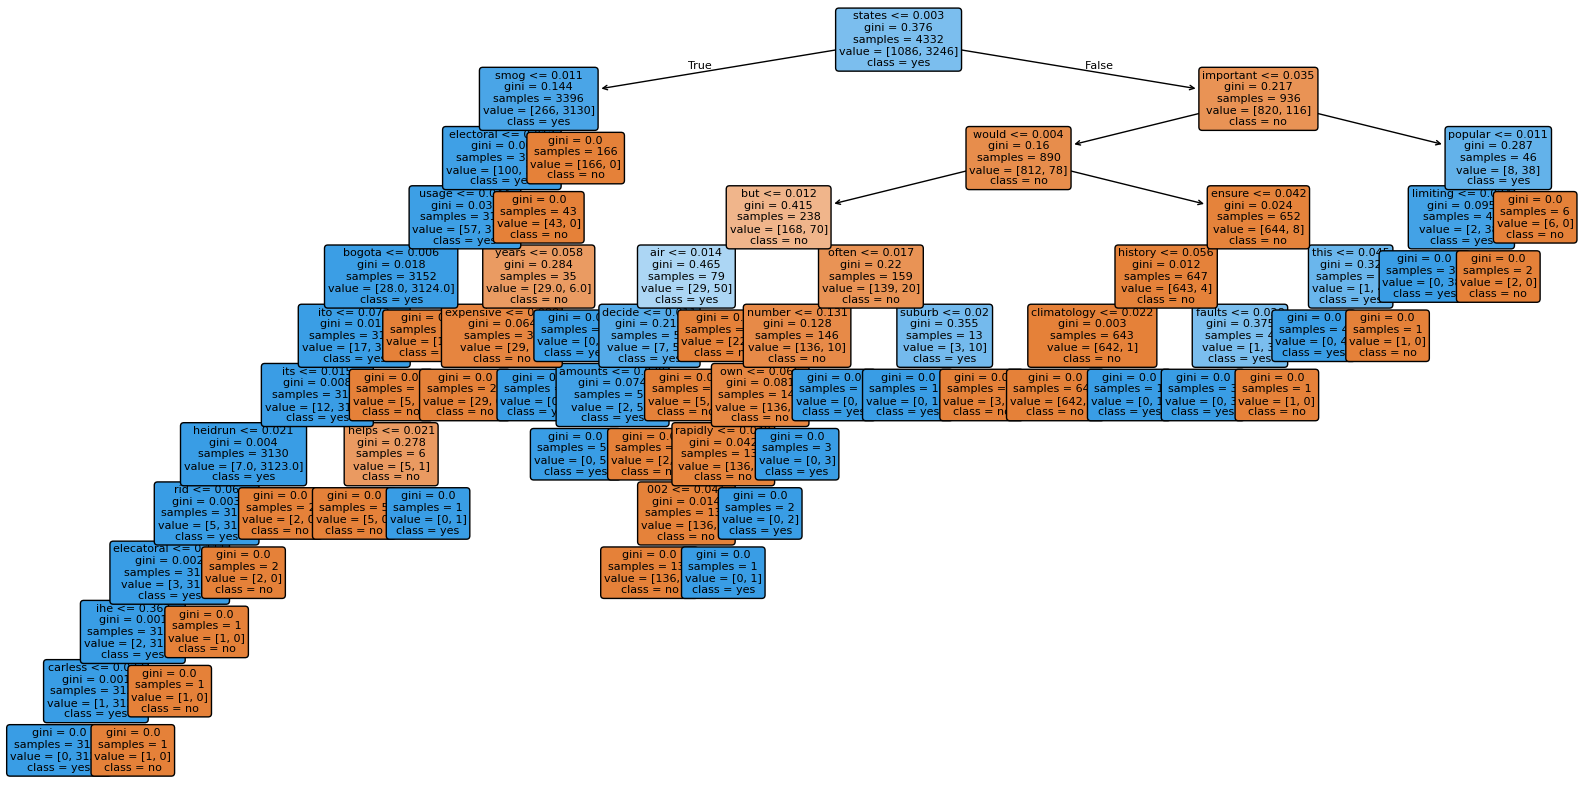

In [44]:
from sklearn import tree

plt.figure(figsize=(20, 10))  # Adjust figure size as needed
tree.plot_tree(tree_pipeline.named_steps['tree'],
               feature_names=tree_pipeline.named_steps['tfidf'].get_feature_names_out(),
               class_names=["no", "yes"],
               filled=True,
               rounded=True,
               fontsize=8)
plt.show()

### KNearest Neighbors with TFIDF

In [45]:
knn_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])


start_time = time.time()
knn_pipe.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_train = knn_pipe.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred = knn_pipe.predict(X_test)
print("Classification Report for TFIDFVectorizer and K Neighbors")
print(classification_report(y_test, y_pred))
test_accuracy=accuracy_score(y_test, y_pred)
print("Accuracy Score",test_accuracy)
print(confusion_matrix(y_test, y_pred))
knn_pred=y_pred

model_results["Model"].append("TFIDF Vectorization+ K Neighbors")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))


Classification Report for TFIDFVectorizer and K Neighbors
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00       795

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy Score 0.9990774907749077
[[289   0]
 [  1 794]]


### Support Vector Classifier with TFIDF

In [46]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(kernel = 'linear'))
])
svc_params = {'svc__C' : [0.1, 1, 10, 100, 1000],
             'svc__probability' : [True, False]}

start_time = time.time()
svc_pipe.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_train = svc_pipe.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred = svc_pipe.predict(X_test)
print("Classification Report for TFIDFVectorizer and Support Vector Machine")
print(classification_report(y_test, y_pred))
test_accuracy=accuracy_score(y_test, y_pred)
print("Accuracy Score",test_accuracy)
print(confusion_matrix(y_test, y_pred))

svc_pred=y_pred
model_results["Model"].append("TFIDF Vectorization+ Support Vector Machine")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))


Classification Report for TFIDFVectorizer and Support Vector Machine
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       289
           1       1.00      1.00      1.00       795

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy Score 0.9981549815498155
[[287   2]
 [  0 795]]


In [47]:
nb_params = {'bayes__alpha' : [1, 0.1, 0.01, 0.001, 0]}
nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bayes', MultinomialNB())
])

start_time = time.time()
nb.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_train = nb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred = nb.predict(X_test)
print("Classification Report for TFIDFVectorizer and Naive Bayes")
print(classification_report(y_test, y_pred))
test_accuracy=accuracy_score(y_test, y_pred)
print("Accuracy Score",test_accuracy)
nb_pred=y_pred
print(confusion_matrix(y_test, y_pred))
model_results["Model"].append("TFIDF Vectorization+  Naive Bayes")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))


Classification Report for TFIDFVectorizer and Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00       795

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy Score 1.0
[[289   0]
 [  0 795]]


In [48]:
models=pd.DataFrame(model_results)
models

,Model,Train Time,Train Accuracy,Test_accuracy,F1Score,Precision,Recall
0,Count Vectorization+ Logistic Regression,48.074285,0.874885,0.868081,0.906840,0.940541,0.875472
1,TFIDF Vectorization+ Logistic Regression,1.138168,0.997692,0.997232,0.998117,0.996241,1.000000
2,TFIDF Vectorization+ Decision Tree,6.357335,1.000000,0.997232,0.979975,0.975093,0.984906
3,TFIDF Vectorization+ K Neighbors,1.106529,0.997230,0.999077,0.999371,1.000000,0.998742
4,TFIDF Vectorization+ Support Vector Machine,5.153619,0.999538,0.998155,0.998744,0.997491,1.000000
5,TFIDF Vectorization+ Naive Bayes,1.403738,0.999077,1.000000,1.000000,1.000000,1.000000


In [49]:
#Grid Search on Support Vector Parameters

svc_grid = GridSearchCV(svc_pipe,svc_params)
svc_grid.fit(X_train,y_train)

test_acc = svc_grid.score(X_test,y_test)
print(svc_grid.best_params_)
print(svc_grid.best_score_)
print(test_acc)
y_pred_grid=svc_grid.predict(X_test)
grid_acc = accuracy_score(y_test, y_pred_grid)

{'svc__C': 10, 'svc__probability': True}
0.9988452655889146
0.9981549815498155


In [50]:
#Grid Search on Naive Bayes Parameters
nb_grid = GridSearchCV(nb,nb_params)
nb_grid.fit(X_train,y_train)

test_acc = nb_grid.score(X_test,y_test)
print(nb_grid.best_params_)
print(nb_grid.best_score_)
print(test_acc)
y_pred_grid=nb_grid.predict(X_test)
grid_acc = accuracy_score(y_test, y_pred_grid)

{'bayes__alpha': 1}
0.9981526913169831
1.0


LDA with TFIDF

Embeddings -LatentDirichletAllocation

In [55]:
# LDA Model

lda_model = LatentDirichletAllocation(n_components=2,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=42)
lda_model.fit(X_train_vec)




LatentDirichletAllocation(learning_method='online', n_components=2,
                          random_state=42)

In [56]:
lda_model.components_

array([[0.60714563, 1.91489908, 0.82730584, ..., 5.54155242, 5.19501474,
        2.12250243],
       [9.48931723, 4.49708858, 2.27959366, ..., 1.02481688, 0.87938733,
        0.94541145]])

In [57]:
lr=LogisticRegression()
X_test_lda = lda_model.transform(X_test_vec)
start_time = time.time()
lr.fit(lda_model.transform(X_train_vec), y_train)
train_time = time.time() - start_time
y_pred_train = lr.predict(lda_model.transform(X_train_vec))
train_accuracy = accuracy_score(y_train, y_pred_train)
y_pred = lr.predict(X_test_lda)
lda_pred=y_pred
print("Classification Report for TFIDFVectorizer and LatentDirichletAllocation")
print(classification_report(y_test, y_pred))
print("Accuracy Score is ", accuracy_score(y_test, y_pred) )
model_results["Model"].append("LatentDirichletAllocation +  Logistic Regression")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))

Classification Report for TFIDFVectorizer and LatentDirichletAllocation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       289
           1       1.00      0.97      0.98       795

    accuracy                           0.98      1084
   macro avg       0.96      0.98      0.97      1084
weighted avg       0.98      0.98      0.98      1084

Accuracy Score is  0.9760147601476015


NMF with TFIDF


In [58]:

nmf_model = NMF(n_components=2, random_state=0)
nmf_model.fit(X_train_vec)



NMF(n_components=2, random_state=0)

In [59]:
start_time = time.time()
lr.fit(nmf_model.transform(X_train_vec), y_train)
train_time = time.time() - start_time
y_pred_train = lr.predict(nmf_model.transform(X_train_vec))
train_accuracy = accuracy_score(y_train, y_pred_train)
X_test_nmf = nmf_model.transform(X_test_vec)
y_pred = lr.predict(X_test_nmf)
nmf_pred=y_pred
print("Classification Report for TFIDFVectorizer and NMF")
print(classification_report(y_test, y_pred))
print("Accuracy Score is ", accuracy_score(y_test, y_pred) )


model_results["Model"].append("TFIDF +  NMF")
model_results["Train Time"].append(train_time)
model_results["Train Accuracy"].append(train_accuracy)
model_results["Test_accuracy"].append(test_accuracy)
model_results["F1Score"].append(f1_score(y_test, y_pred))
model_results["Precision"].append(precision_score(y_test, y_pred))
model_results["Recall"].append(recall_score(y_test, y_pred))

Classification Report for TFIDFVectorizer and NMF
              precision    recall  f1-score   support

           0       1.00      0.51      0.67       289
           1       0.85      1.00      0.92       795

    accuracy                           0.87      1084
   macro avg       0.92      0.75      0.80      1084
weighted avg       0.89      0.87      0.85      1084

Accuracy Score is  0.8690036900369004


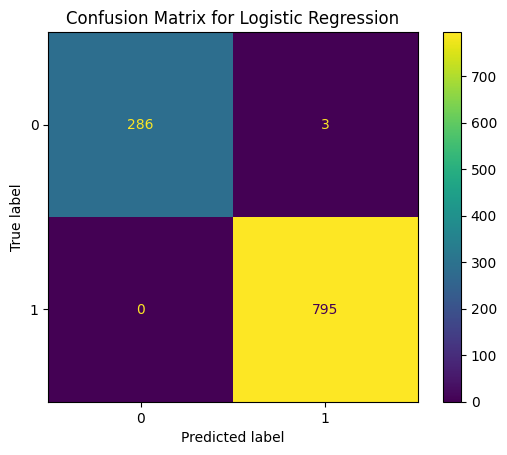

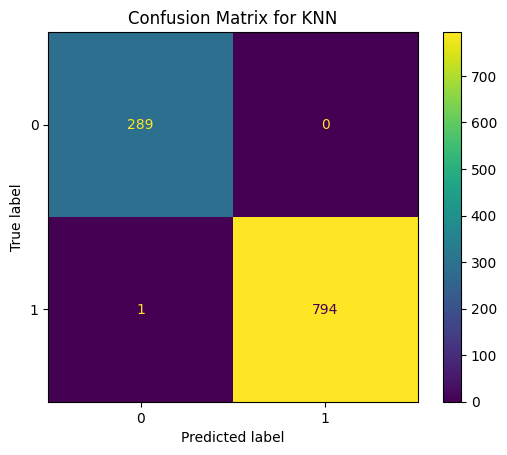

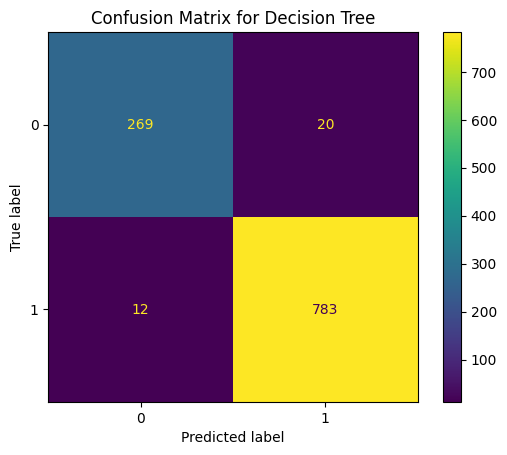

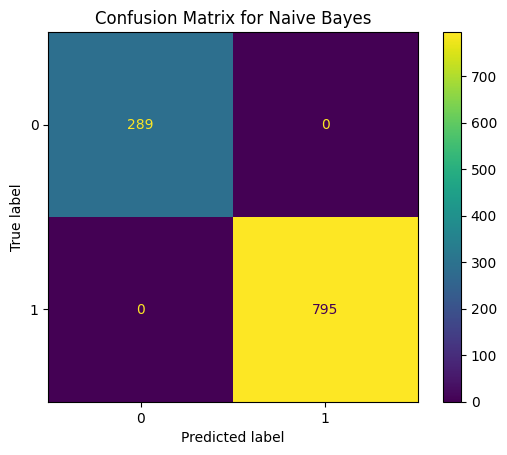

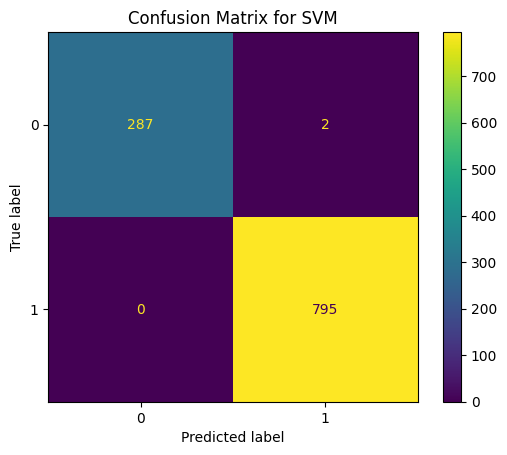

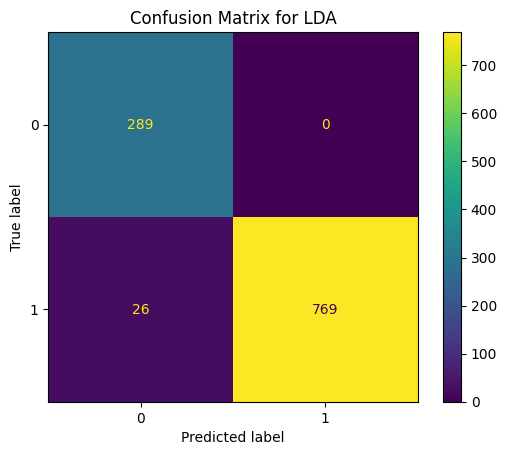

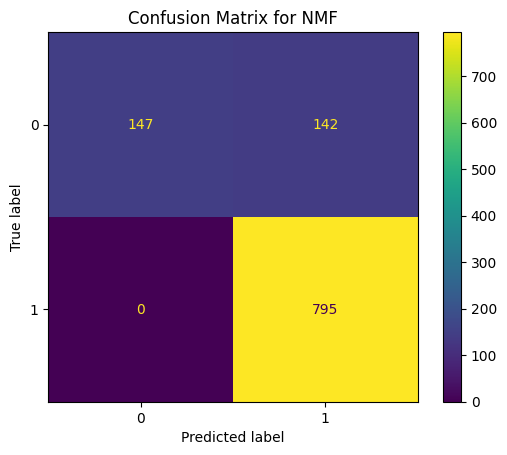

In [62]:
models_predictions = {
    "Logistic Regression": lr_pred,
    "KNN": knn_pred,
    "Decision Tree": tree_pred,
    "Naive Bayes": nb_pred,
    "SVM": svc_pred,
    "LDA": lda_pred,
    "NMF": nmf_pred
}

for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [63]:
models=pd.DataFrame(model_results)
models

,Model,Train Time,Train Accuracy,Test_accuracy,F1Score,Precision,Recall
0,Count Vectorization+ Logistic Regression,48.074285,0.874885,0.868081,0.906840,0.940541,0.875472
1,TFIDF Vectorization+ Logistic Regression,1.138168,0.997692,0.997232,0.998117,0.996241,1.000000
2,TFIDF Vectorization+ Decision Tree,6.357335,1.000000,0.997232,0.979975,0.975093,0.984906
3,TFIDF Vectorization+ K Neighbors,1.106529,0.997230,0.999077,0.999371,1.000000,0.998742
4,TFIDF Vectorization+ Support Vector Machine,5.153619,0.999538,0.998155,0.998744,0.997491,1.000000
5,TFIDF Vectorization+ Naive Bayes,1.403738,0.999077,1.000000,1.000000,1.000000,1.000000
6,LatentDirichletAllocation + Logistic Regression,0.817543,0.966528,1.000000,0.983376,1.000000,0.967296
7,TFIDF + NMF,0.034207,0.864035,1.000000,0.918014,0.848453,1.000000
8,TFIDF Vectorization+ Logistic Regression,1.112422,0.997692,0.997232,0.998117,0.996241,1.000000
